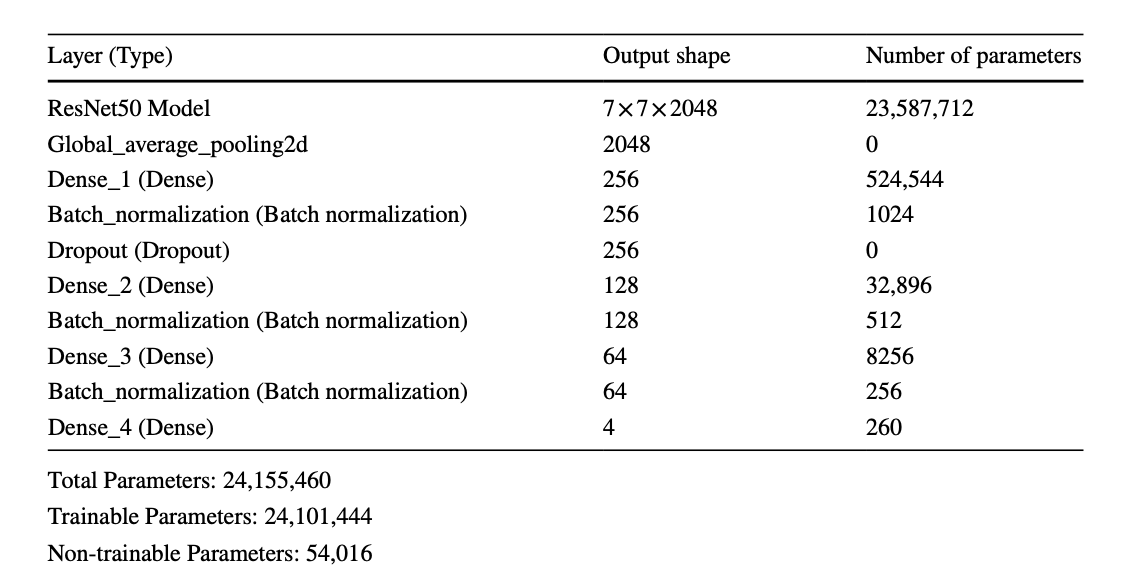

Using ResNet from Pytorch library

# Load scans from filepaths into Dataset-derived class

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
from google.colab import drive
import numpy as np
import  matplotlib.pyplot as plt
from PIL import Image
import csv
import cv2 # for extract tiff scans

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


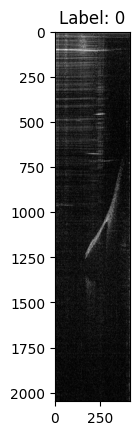

In [ ]:

class OCTDataset(Dataset):
  def __init__(self, csv_file_path):
    self.samples = []
    self.labels = []

    with open(csv_file_path, 'r') as f:
      reader = csv.reader(f)
      for row in reader:
        self.samples.append(row[0])
        self.labels.append(int(row[1]))

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, index):
    # temporary solution that just retrieves 200th slice by default
    if isinstance(index, tuple):
      idx, slice_idx = index
    else:
      idx, slice_idx = index, 200

    file_path = self.samples[idx]
    label = self.labels[idx]

    # open filepath and make into a numpy array
    ret, images = cv2.imreadmulti(file_path, [])
    img = np.asarray(images)

    ''' if img.shape != (417, 2048, 417):
      x_pad = 417 - img.shape[0]
      y_pad = 2048 - img.shape[1]
      z_pad = 417 - img.shape[2]
      img = np.pad(img, pad_width=( ((x_pad+1)//2, x_pad//2), ((y_pad+1)//2, y_pad//2), ((z_pad+1)//2, z_pad//2) ), mode='constant')
    '''
    # return entire image, array of slices
    # return img, label, file_path

    # return 200th slice, in middle of image
    ''' data = {
        'img': img[200],
        'label': label,
        'path': file_path
    } '''
    image = Image.fromarray(img[200]).convert('RGB')
    image = np.array(image)

    if image.shape != (2048, 417, 3):
      x_pad = 2048 - image.shape[0]
      y_pad = 417 - image.shape[1]
      image = np.pad(image, pad_width=( ((x_pad+1)//2, x_pad//2), ((y_pad+1)//2, y_pad//2), (0, 0) ), mode='constant')
    return image, label, file_path

csv_path = '/content/drive/MyDrive/proj-applegate/src/PATHS2.csv'

oct_dataset = OCTDataset(csv_path)

''' for i in range(len(oct_dataset.samples)):
  print(oct_dataset.samples[i].shape) '''

sample_image, sample_label, path = oct_dataset[0]

# num_slices = np.shape(sample_image)[2]

plt.imshow(sample_image, cmap='gray')
# print("number of slices: {} ".format(num_slices))

plt.title(f"Label: {sample_label}")
plt.show()


# Define model

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
import torch.optim as optim
import sys

In [ ]:
class finetuned_resnet(nn.Module):
  def __init__(self):
    super(finetuned_resnet, self).__init__()

    # to answer claude's question, input size is 224 x 224 x 3 according to
    # Load the pre-trained ResNet50 model
    model = resnet50(pretrained=True)

    # Remove the fully connected layers at the end
    self.model = nn.Sequential(*list(model.children())[:-2])

    # Add new layers
    out1 = 256
    out2 = 128
    out3 = 32
    out4 = 16
    self.avg = nn.AdaptiveAvgPool2d(out1)
    self.d1 = nn.Linear(out1, out2)
    #self.batch_norm1 = nn.BatchNorm2d(out2)
    #self.dropout = nn.Dropout()
    #self.d2 = nn.Linear(out2, out3)
    #self.batch_norm2 = nn.BatchNorm2d(out3)
    #self.d3 = nn.Linear(out3, out4)
    #self.batch_norm3 = nn.BatchNorm2d(out4)
    #self.d4 = nn.Linear(out4, 2) # change for number of classes at the end
    self.d4 = nn.Linear(out2, 2) # change for number of classes at the end

  def forward(self, x):
    # Forward pass through the ResNet50 backbone
    print('starting pass')
    x = self.model(x)
    print(sys.getsizeof(x))
    print('passed model')

    x = self.avg(x)
    print(1)
    x = self.d1(x)
    print(2)
    # x = self.batch_norm1(x)
    # print(3)
    # x = self.dropout(x)
    # print(4)
    # x = self.d2(x)
    # print(5)
    # x = self.batch_norm2(x)
    # print(6)
    # x = self.d3(x)
    # print(7)
    # x = self.batch_norm3(x)
    # print(8)
    # x = self.d4(x)
    print('passed once')

    return x

# Example usage
num_classes = 10  # Change this according to your task
custom_resnet = finetuned_resnet()

# Print the custom ResNet50 architecture
print(custom_resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


finetuned_resnet(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

# Train model

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
import sys
torch.cuda.empty_cache()


# use GroupShuffleSplit and DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_idx, val_idx = next(sss.split(oct_dataset.samples, oct_dataset.labels))

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

batch_size = 8
train_loader = DataLoader(oct_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(oct_dataset, batch_size=batch_size, sampler=val_sampler)

# data_loader = DataLoader(oct_dataset, batch_size=batch_size, shuffle=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
#model = finetuned_resnet()
model = resnet50(pretrained=True)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, paths in train_loader:
      inputs = inputs.permute(0, 3, 1, 2)
      inputs, labels = inputs.to(device), torch.tensor(labels).to(device)

      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs.float())

      # Compute the loss
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels, paths in val_loader:
            inputs = inputs.permute(0, 3, 1, 2)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-5-63230d4e7110>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)


KeyboardInterrupt: ignored

# Evaluate model

In [ ]:
patients = {}
# should be a dictionary with key = v1 through v8
#                             value = array of filepaths (not file names) to volume tiffs

if not os.path.isfile('/content/drive/MyDrive/proj-applegate/src/PATHS.txt'):
  with open('/content/drive/MyDrive/proj-applegate/src/PATHS.txt', 'w') as file:
    for root, _, files in os.walk('/content/drive/MyDrive/proj-applegate/VolunteerNormals'):
      for f in files:
        if f.endswith('.tiff'):
          file.write(os.path.join(root, f)+'\n')

for line in open('/content/drive/MyDrive/proj-applegate/src/PATHS.txt', 'r'):
  if line[0] == '#':
    continue
  if line[2:4] in patients:
    patients[line[2:4]].append(line)
  else:
    patients[line[2:4]] = [line]

label_mapping = {
    "v1": 0, "v2": 0, "v3": 0, "v4": 0, "v5": 0, "v6": 0, "v7": 0, "v8": 0, }
    # all label zero because they are normal patients, no patholgies


# IGNORE OCTDATASET BELOW FOR NOW, issues with npz(?)

class OCTDataset(Dataset):
  def __init__(self, csv_file_path):
    self.samples = []
    self.labels = []

    with open(csv_file_path, 'r') as f:
      reader = csv.reader(f)
      for row in reader:
        self.samples.append(row[0])
        self.labels.append(row[1])

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, index):
    # # temporary solution that just retrieves 200th slice by default
    # if isinstance(index, tuple):
    #   idx, slice_idx = index
    # else:
    #   idx, slice_idx = index, 200

    # file_path = self.samples[idx]
    # label = self.labels[idx]

    # # open filepath and make into a numpy array
    # images = []
    # ret, images = cv2.imreadmulti(file_path, images)

    # img = np.asarray(images)

    # # returns a singular image slice when specified the index
    # '''
    # dim_x = np.shape(img)[0]
    # dim_y = np.shape(img)[1]
    # num_slices = np.shape(img)[2]
    # return img[slice_idx], label, file_path, num_slices
    # '''

    # # OR

    # # return entire image, array of slices
    # return img, label #, file_path

    # # ^ also temporarily added the file path of the image as the last
    # # element when getting an tiem, just so i can identify images if need be

    # npz_file_path = self.samples[index]
    # label = self.labels[index]

    # Load the .npz file
    data = np.load(self.samples)

    # Extract scan, patient, and diagnosis
    scan = data['scan']
    patient = data['patient']
    diagnosis = data['diagnosis']

    # Convert to PyTorch tensors
    scan = torch.from_numpy(scan).float()
    diagnosis = torch.tensor(diagnosis)
    patient = torch.tensor(patient)

    # Combine into a single list
    sample = [scan, diagnosis, patient]

    return sample, diagnosis

csv_path = '/content/drive/MyDrive/proj-applegate/src/PATHS.csv'
# npz_path = '/content/drive/MyDrive/proj-applegate/src/cholesteatoma_data.npz'

oct_dataset = OCTDataset(npz_path)

# sample_image, sample_label = oct_dataset[0, 200] # image 0 slice 200
sample_image, sample_label = oct_dataset[0] # image 0 slice 0 (probably?)

# , sample_image_path
# num_slices = np.shape(sample_image)[2]

plt.imshow(sample_image[200], cmap='gray')
# print("number of slices: {} ".format(num_slices))

plt.title(f"Label: {sample_label}")
plt.show()


UnicodeDecodeError: ignored

In [2]:
# testing
class OCTDataset(Dataset):
    def __init__(self, csv_file_path):
        self.data = np.load(csv_file_path)
        self.keys = list(self.data.keys())  # keys are data and meta

    def __len__(self):
        return len(self.data)  # revisit

    def __getitem__(self, index):
        img = self.data['data'][index]
        diagnosis = self.data['meta'][index]

        #[ [scan numpy 3darray], [diagnosis, patient] ]
        return [img, diagnosis]




In [ ]:
npz_path = '/content/drive/MyDrive/proj-applegate/src/cholesteatoma_data.npz'


dataset = OCTDataset(npz_path)
print(np.shape(dataset))
sample = dataset[0] # index should correspond to row in npz file
#sample now contains a tuple that has the image itself, the diagnosis, and the patient number
print(sample)
plt.imshow(sample[0], cmap='gray')


# plt.title(f"Label: {sample_label}")
plt.show()


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim


# use GroupShuffleSplit and DataLoader
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_idx, val_idx = next(gss.split(oct_dataset.samples,
                                    groups=[i for i in range()])) # what are our labels?

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

batch_size = 32
train_loader = DataLoader(oct_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=True)
val_loader = DataLoader(oct_dataset, batch_size=batch_size, sampler=val_sampler, shuffle=True)

# data_loader = DataLoader(oct_dataset, batch_size=batch_size, shuffle=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = finetuned_resnet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (sample_image, sample_label, sample_image_path, num_slices) in enumerate(train_loader):
      images = data_loader #for i in num_slices
      print(np.shape(images))
      images = torch.stack(images).to(device)

      optimizer.zero_grad()

      # Forward pass
      outputs = model(images)

      # Compute the loss
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    # Print the average loss for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(data_loader)}')





    # for batch_idx, (indices, labels, file_paths, num_slices) in enumerate(data_loader):
    #     if not isinstance(indices, tuple):
    #         indices = (indices,)  # Ensure indices is a tuple

    #     # images = [data_loader[i][0] for i in indices]
    #     images = [data_loader[i] for i in indices]

    #     images = torch.stack(images).to(device)

    #     optimizer.zero_grad()

    #     # Forward pass
    #     outputs = model(images)

    #     # Compute the loss
    #     loss = criterion(outputs, labels)

    #     # Backward pass and optimization
    #     loss.backward()
    #     optimizer.step()

    #     running_loss += loss.item()

    # # Print the average loss for this epoch
    # print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(data_loader)}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


()


TypeError: ignored